Here we are going to benchmark chewbbaca, taranys and seqshpere using three different datasets:
- ECDC EQA - mtuberculosis
- Halbedel et al. 2019 - lmonocytogenes
- UNSGM PT3 - bmelitensis

In [2]:
! pip install pandas matplotlib seaborn numpy

In [3]:
# Imports
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations


def print_tree(directory, prefix=''):
    """Recursively prints a tree view of the directory structure."""
    files = sorted(os.listdir(directory))
    for index, file in enumerate(files):
        path = os.path.join(directory, file)
        is_last = index == len(files) - 1
        print(prefix + '└── ' if is_last else prefix + '├── ', file)
        if os.path.isdir(path):
            extension = '    ' if is_last else '│   '
            print_tree(path, prefix=prefix+extension)

# move to working directory
os.chdir("/home/smonzon/temp/comparison")
print_tree(os.getcwd())

├──  bmelitensis
│   ├──  .~lock.results_alleles_chewbbaca.tsv#
│   ├──  .~lock.summary_taranys.csv#
│   ├──  cluster_per_locus_80.csv
│   ├──  cluster_per_locus_85.csv
│   ├──  cluster_per_locus_90.csv
│   ├──  distance_chewbbaca
│   │   ├──  allele_matrix_fil.csv
│   │   ├──  allele_matrix_fil.tsv
│   │   ├──  distance_matrix.csv
│   │   └──  distance_matrix_core.csv
│   ├──  distance_seqsphere
│   │   ├──  allele_matrix_fil.csv
│   │   ├──  allele_matrix_fil.tsv
│   │   ├──  distance_matrix.csv
│   │   └──  distance_matrix_core.csv
│   ├──  distance_taranys
│   │   ├──  allele_matrix_fil.csv
│   │   ├──  allele_matrix_fil.tsv
│   │   ├──  distance_matrix.csv
│   │   └──  distance_matrix_core.csv
│   ├──  results_alleles_chewbbaca.csv
│   ├──  results_alleles_chewbbaca.tsv
│   ├──  results_alleles_chewbbaca_masked.tsv
│   ├──  results_alleles_seqsphere.ccsv
│   ├──  results_alleles_seqsphere.csv
│   ├──  results_alleles_taranys.csv
│   ├──  summary_chewbbaca.csv
│   ├──  summary_chew

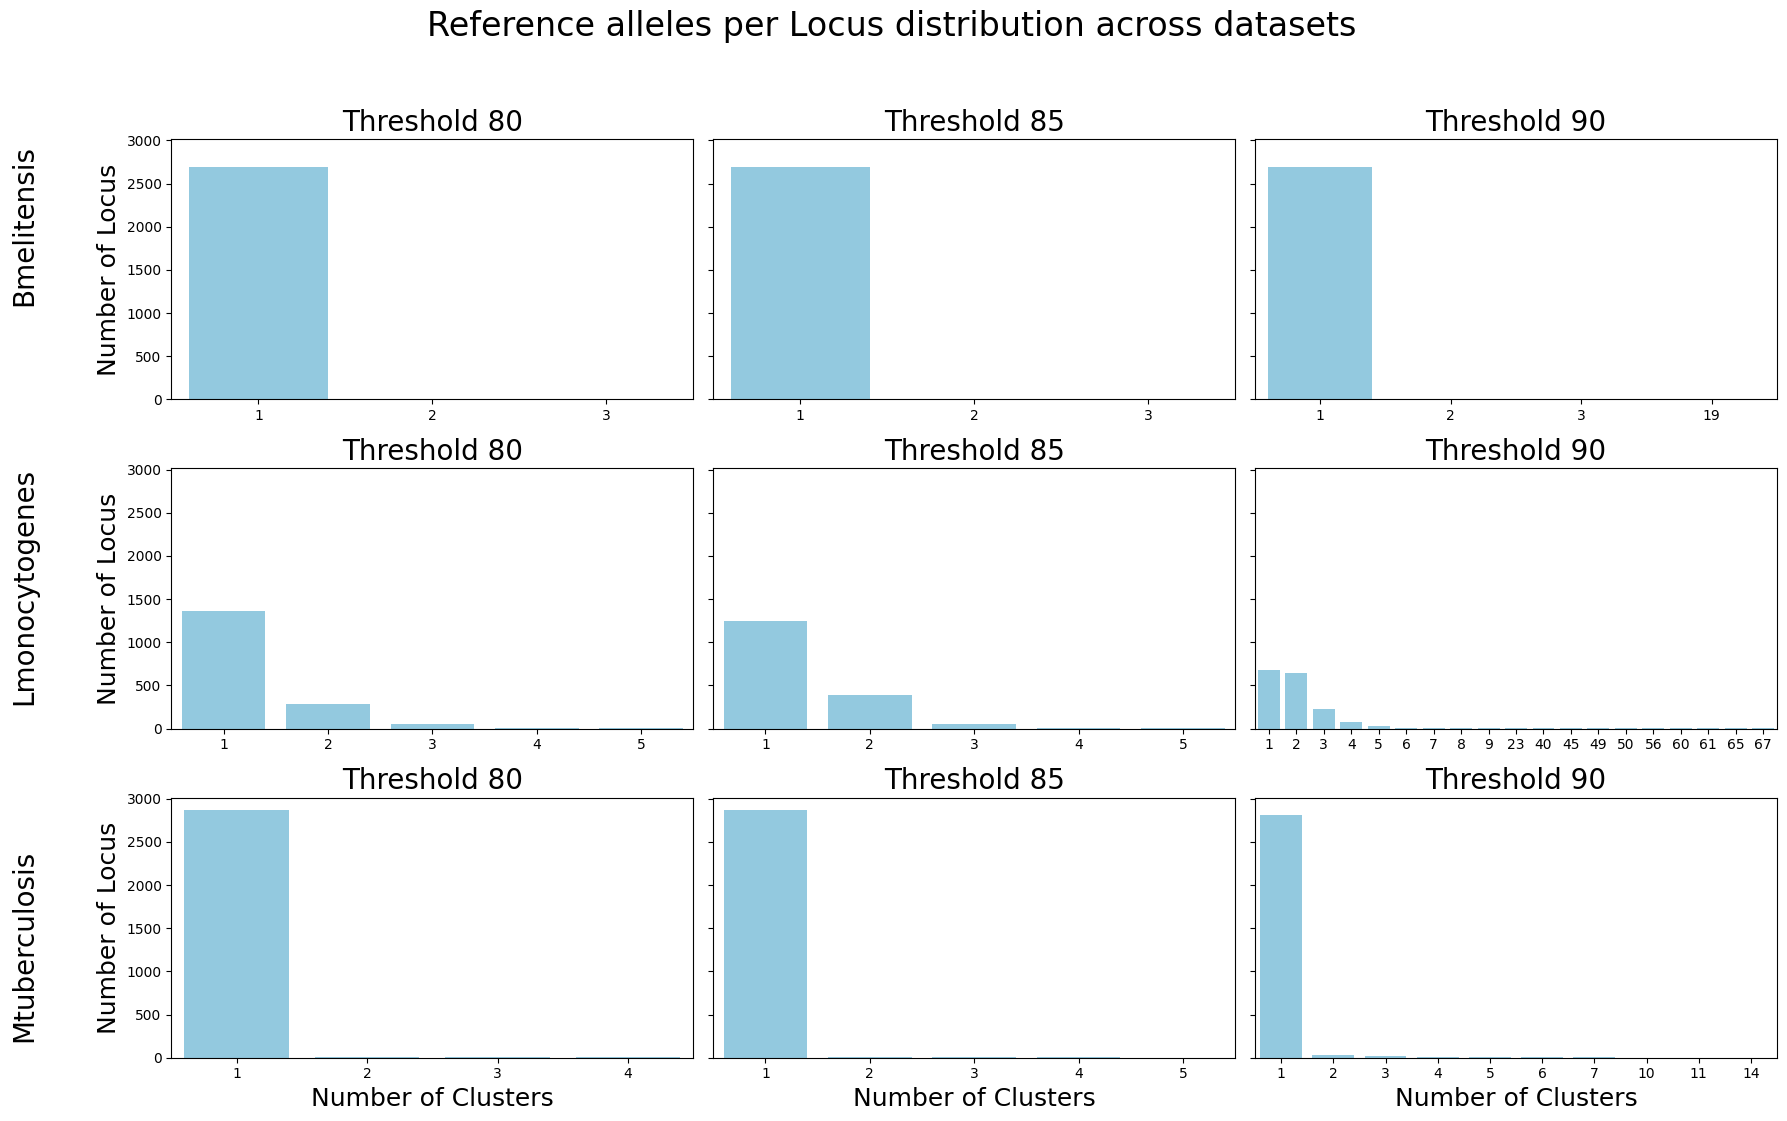

In [2]:
# Graph reference alleles per locus
datasets = ["bmelitensis", "lmonocytogenes", "mtuberculosis"]
thresholds = ["80", "85", "90"]
df_num_ref = pd.DataFrame()
for dataset in datasets:
    for thr in thresholds:
        df = pd.read_csv(f"./{dataset}/cluster_per_locus_{thr}.csv")
        df["Dataset"] = dataset
        df["Threshold"] = thr
        df_num_ref = pd.concat([df_num_ref, df], ignore_index=True)

# Set up the figure for a 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=False, sharey=True)
fig.suptitle('Reference alleles per Locus distribution across datasets', fontsize = 24)

# Iterate over each dataset and threshold to create a subplot
for i, dataset in enumerate(datasets):
    for j, thr in enumerate(thresholds):
        ax = axes[i, j]
        # Filter the dataframe for the current dataset and threshold
        subset = df_num_ref[(df_num_ref['Dataset'] == dataset) & (df_num_ref['Threshold'] == thr)]
        # Plotting the distribution of the number of locus per number of clusters
        sns.barplot(data=subset, x='number of clusters', y=' number of locus', ax=ax, color='skyblue')
        
        # Set subplot title
        ax.set_title(f'Threshold {thr}', fontsize=20)
        
        # Set labels
        ax.set_xlabel('Number of Clusters' if i == 2 else '', fontsize=18)  # Only label x-axis for the bottom row
        ax.set_ylabel('Number of Locus' if j == 0 else '', fontsize=18)    # Only label y-axis for the first column
        ax.tick_params(axis='both', which='major', labelsize=15)

for i, dataset in enumerate(datasets):
    fig.text(0.01, 0.8 - i * 0.3, dataset.capitalize(), va='center', rotation='vertical', fontsize=20)

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust the rect to prevent overlap and to leave space for the suptitle

# Save and show the figure
plt.savefig("locus_distribution.png", dpi=300)
plt.show()

In [5]:
# Check summary results
datasets = ["bmelitensis", "lmonocytogenes", "mtuberculosis"]
software = ["taranys", "chewbbaca", "seqsphere"]
final_summary_table = pd.DataFrame()

for dataset in datasets:
    for soft in software:
        summary_table = pd.read_csv(f"./{dataset}/summary_{soft}.csv", delimiter=",")
        column_totals = summary_table.drop(columns=['Sample']).sum()
        # Calculate the grand total of these totals
        grand_total = column_totals.sum()
        # Calculate the percentage of each column total relative to the grand total
        percentage_totals = (column_totals / grand_total * 100).round(2)
        # Convert to DataFrame for better presentation
        percentage_summary_table = percentage_totals.reset_index()
        percentage_summary_table.columns = ['Type', '% of Total']
        # Add columns for 'Software' and 'Dataset'
        percentage_summary_table['Software'] = soft
        percentage_summary_table['Dataset'] = dataset
        
        # Append the result to the final DataFrame
        final_summary_table = pd.concat([final_summary_table, percentage_summary_table], ignore_index=True)

final_summary_table.to_csv("summary_comparison.csv")
print(final_summary_table)

      Type  % of Total   Software        Dataset
0   NIPHEM        0.00    taranys    bmelitensis
1     NIPH        0.07    taranys    bmelitensis
2      EXC       95.12    taranys    bmelitensis
3     PLOT        0.03    taranys    bmelitensis
4      ASM        0.00    taranys    bmelitensis
..     ...         ...        ...            ...
61     ASM        0.93  chewbbaca  mtuberculosis
62    PAMA        0.03  chewbbaca  mtuberculosis
63     LNF        5.18  chewbbaca  mtuberculosis
64     EXC       90.13  seqsphere  mtuberculosis
65     LNF        9.87  seqsphere  mtuberculosis

[66 rows x 4 columns]


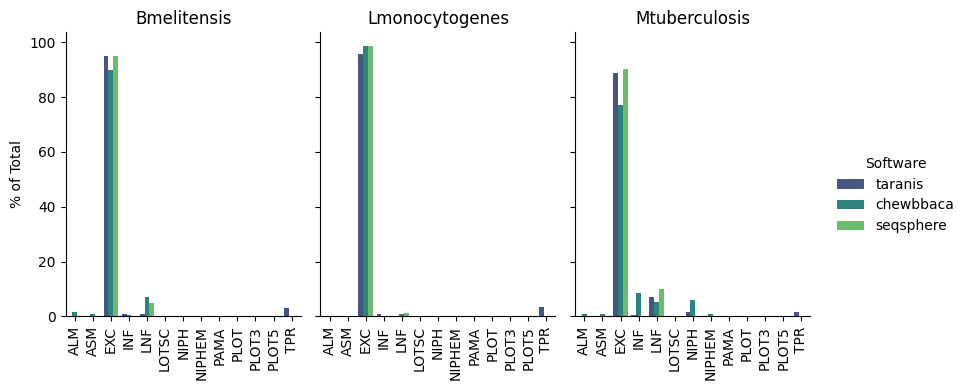

In [6]:
# Plot summary data

# Sort the types alphabetically and get the unique sorted list for ordering in the plot
type_order = sorted(final_summary_table['Type'].unique())

# Create a faceted plot: each software/dataset combination gets a subplot
g = sns.catplot(
    data=final_summary_table,
    kind="bar",
    x="Type",
    y="% of Total",
    hue="Software",
    col="Dataset",
    palette="viridis",
    aspect=0.7,
    height=4,
    order=type_order  # Order the x-axis categories alphabetically
)

# Improve the readability of the plot
g.set_xticklabels(rotation=90)  # Rotate x labels for better visibility
g.set_titles("{col_name}")  # Set titles to be just the dataset names
g.set_axis_labels("", "% of Total")  # Set axis labels

for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(title.capitalize())  # Capitalize each subplot title
    
g.tight_layout()  # Adjust subplots to fit into figure area.

# Show plot
plt.savefig("summary_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()
plt.close()  # Close the plot to free up memory

bmelitensis-seqsphere
[1766 1816 1817 ... 1885 1793 1922]
[1745 1778 1778 ... 1837 1750 1856]
[[1.         0.99974054]
 [0.99974054 1.        ]]
bmelitensis-seqsphere-0.9997405443579204
bmelitensis-seqsphere
[1766 1816 1817 ... 1885 1793 1922]
[ nan  nan  nan ... 685. 656. 693.]
[[ 1. nan]
 [nan nan]]
bmelitensis-seqsphere-nan
bmelitensis-seqsphere
[ 221 1778  276 ... 1837 1750 1856]
[ nan  nan  nan ... 685. 656. 693.]
[[ 1. nan]
 [nan nan]]
bmelitensis-seqsphere-nan
lmonocytogenes-seqsphere
[24 55 31 46 89 29 24 29 29 30 32 35 32 30 29 33 31 30 31 32 55 30 30 34
 31 29 33 29 34 30 49 29 40 85 24 22 24 24 25 27 30 27 25 24 27 26 25 26
 27 49 25 26 29 26 24 28 24 29 25 61 48 86 57 54 57 56 58 59 61 60 58 56
 59 58 57 58 60  0 58 56 60 58 56 59 57 59 57 51 94 34 25 34 34 35 37 40
 36 34 34 38 35 35 36 37 61 35 36 39 36 34 38 34 39 35 83 45 44 45 46 47
 48 51 49 46 45 50 48 47 46 48 48 46 44 50 47 46 48 46 49 46 89 89 90 90
 90 92 95 92 90 89 94 92 91 92 93 86 91 88 93 91 90 92 90 94 91 2

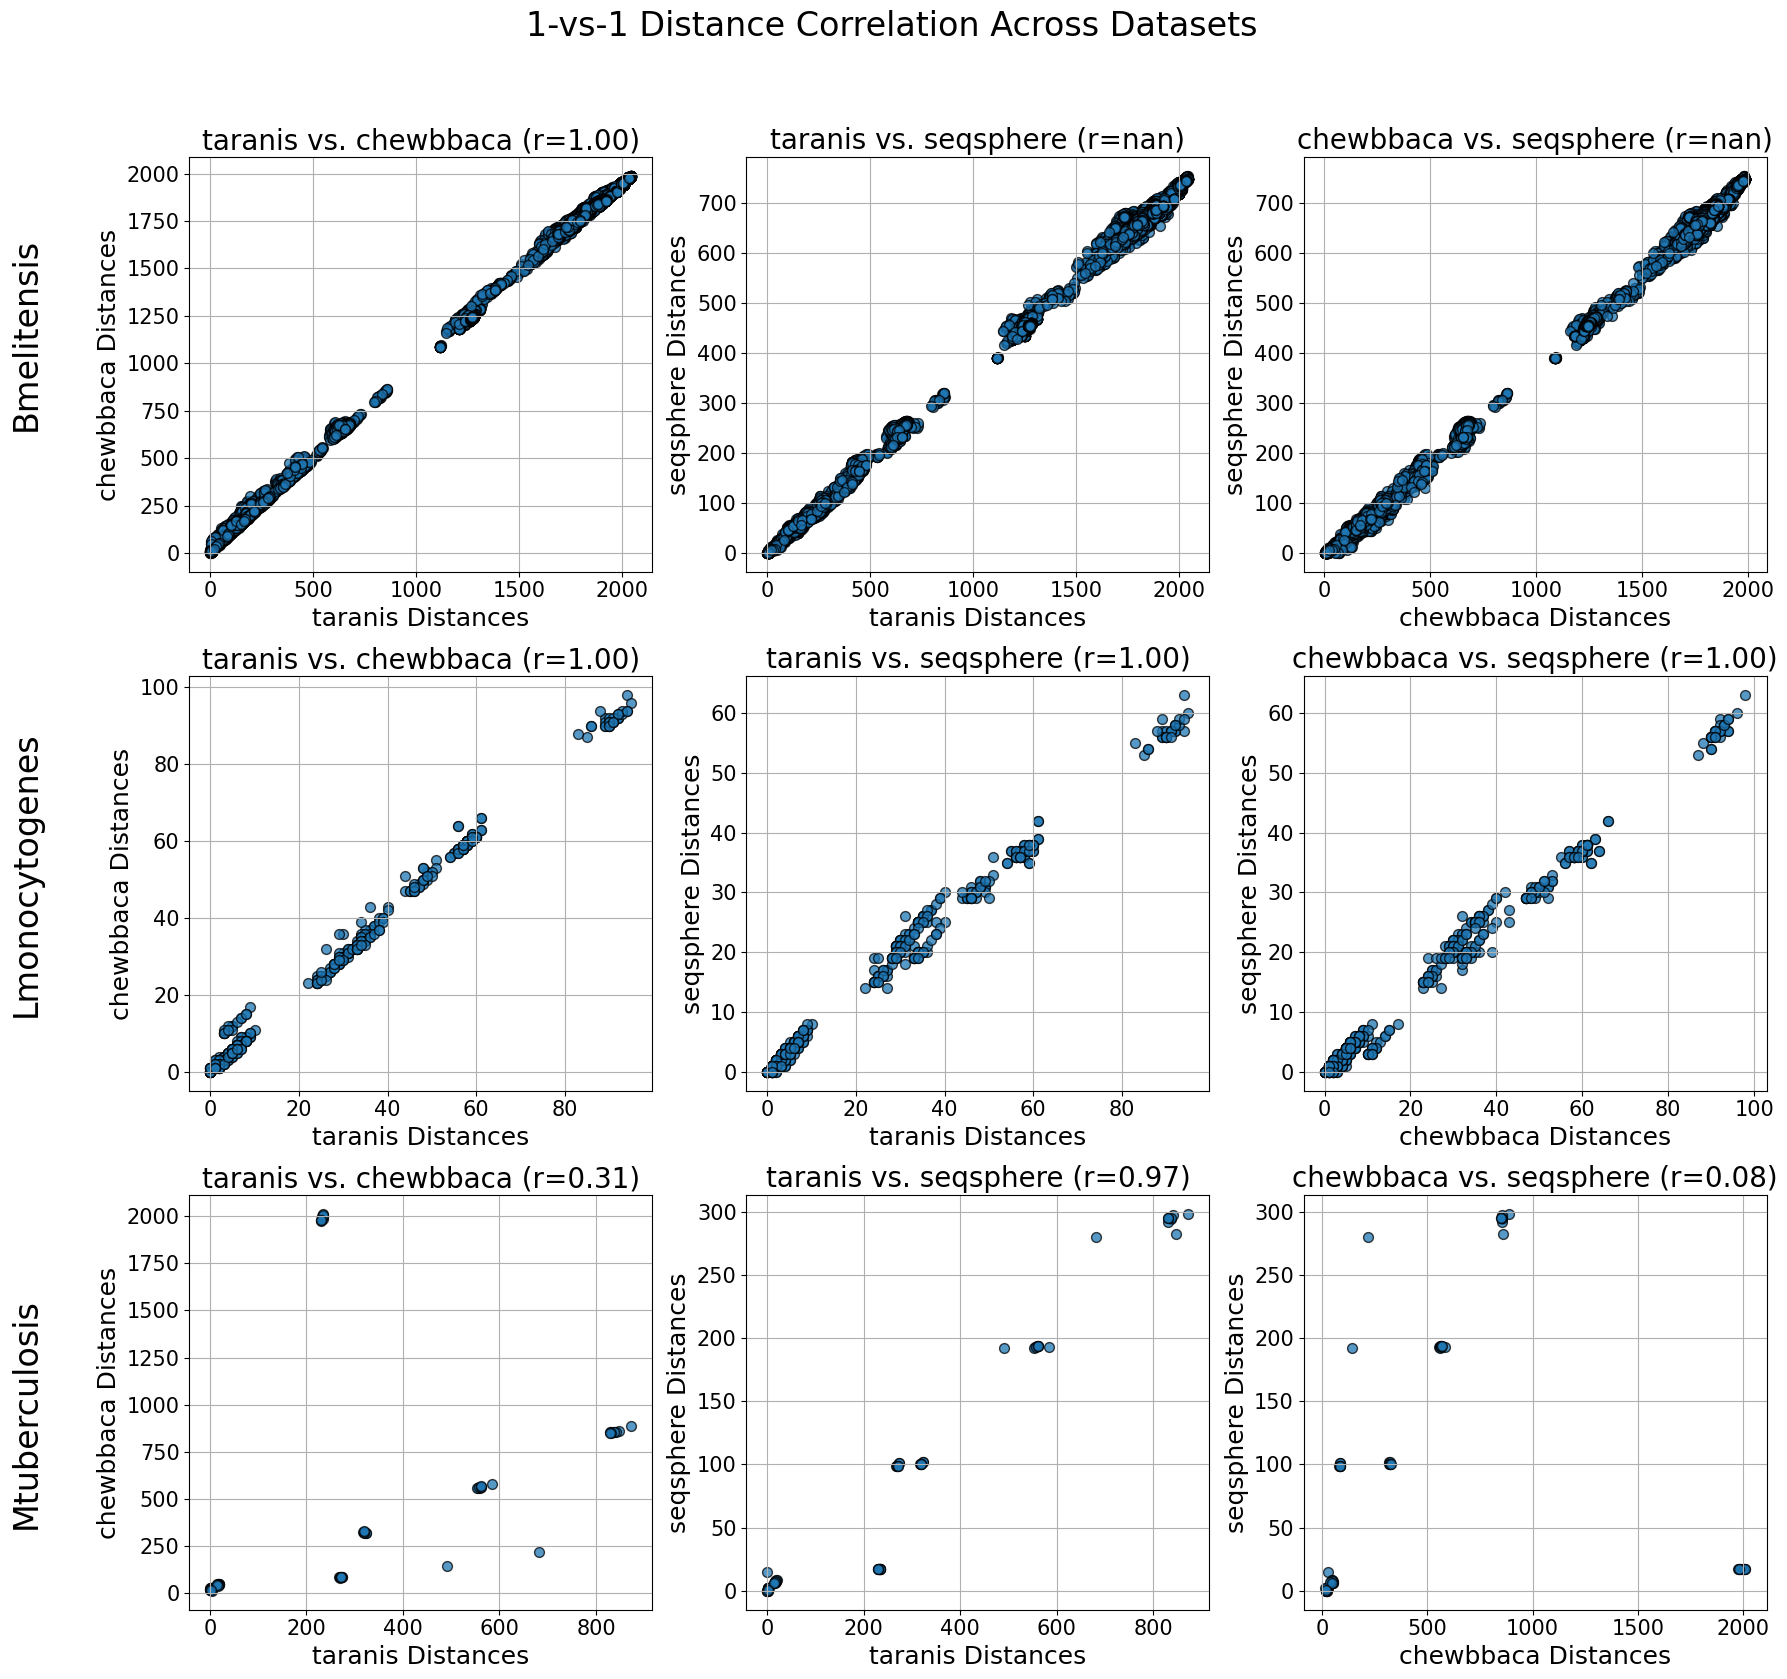

In [12]:
# Datasets and software tools
datasets = ["bmelitensis", "lmonocytogenes", "mtuberculosis"]
software = ["taranys", "chewbbaca", "seqsphere"]

# Function to extract upper triangle of the matrix without the diagonal
def get_upper_triangle(matrix):
    triu_indices = np.triu_indices_from(matrix, k=1)
    return matrix.values[triu_indices]

# Setup the figure and axes for the subplots
fig, axes = plt.subplots(len(datasets), len(list(combinations(software, 2))), figsize=(18, 18))
fig.suptitle('1-vs-1 Distance Correlation Across Datasets', fontsize=24)

# Iterate over each dataset and software combination
for row, dataset in enumerate(datasets):
    for col, (soft1, soft2) in enumerate(combinations(software, 2)):
        matrix1 = pd.read_csv(f"./{dataset}/distance_{soft1}/distance_matrix.csv", index_col=0)
        matrix2 = pd.read_csv(f"./{dataset}/distance_{soft2}/distance_matrix.csv", index_col=0)
        print(matrix1)
        print(matrix2)
        
        matrix2 = matrix2.reindex(index=matrix1.index, columns=matrix1.columns)
        flat_matrix1 = get_upper_triangle(matrix1)
        flat_matrix2 = get_upper_triangle(matrix2)
        print(flat_matrix1)
        print(flat_matrix2)
        print(np.corrcoef(flat_matrix1, flat_matrix2))
        correlation = np.corrcoef(flat_matrix1, flat_matrix2)[0, 1]
        print(f"{dataset}-{soft}-{correlation}")
        ax = axes[row][col]
        ax.scatter(flat_matrix1, flat_matrix2, edgecolors='k', alpha=0.75, s=50)
        ax.set_title(f"{soft1} vs. {soft2} (r={correlation:.2f})", fontsize=20)
        ax.set_xlabel(f"{soft1} Distances", fontsize=18)
        ax.set_ylabel(f"{soft2} Distances", fontsize=18)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=15)

# Adding dataset-specific titles along the left side
for i, dataset in enumerate(datasets):
    fig.text(0.01, 0.8 - i * 0.3, dataset.capitalize(), va='center', rotation='vertical', fontsize=24)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust the left margin to make space for the dataset label


# save fig
plt.savefig("distance_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
# Show plot
plt.show()